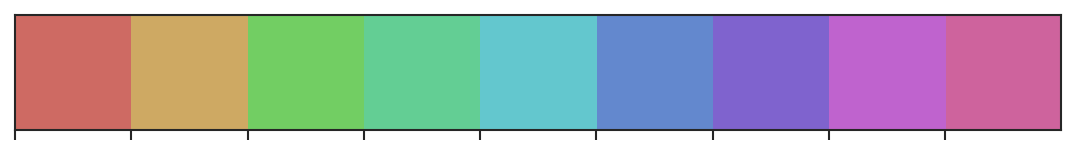

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import numba
from scipy import signal
from tqdm import tqdm


sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]


In [95]:

@numba.njit
def x_dot_init(x, y, V, params):
    dxdt = params[0]*V - (params[1] + params[3]) * x + params[2]/(V**2) * x**2 * y
    return dxdt

@numba.njit
def y_dot_init(x, y, V, params):
    dydt = params[1]*x - params[2]/(V**2) * x**2 * y
    return dydt
    
@numba.njit
def x_mark(V, params):
    return params[0]*V / params[3]

@numba.njit
def y_mark(V, params):
    return V * params[1] * params[3] / (params[2] * params[0])


@numba.njit
def delta(params):
    return params[2]*params[0]**2 / (params[3]**2)

@numba.njit
def tau(params):
    return params[1] - params[3] - delta(params)

@numba.njit
def anafreq(params):
    return (1/2 * np.sqrt(4*delta(params) - tau(params)**2))/(2 * np.pi)

@numba.njit
def alpha(params):
    return tau(params)/2


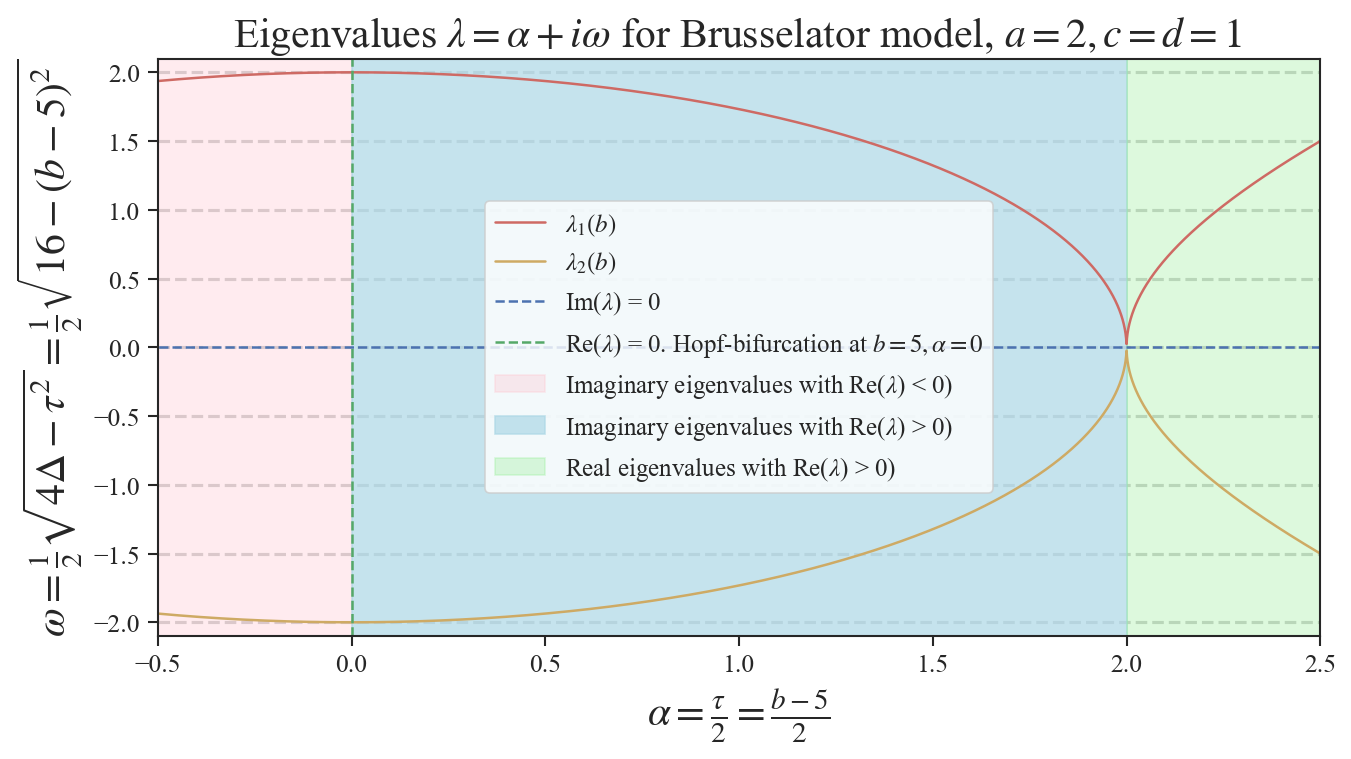

In [96]:
# Hopf bifurcation

@numba.njit
def anafreq_mod(params):
    return (1/2 * np.sqrt(abs(4*delta(params) - tau(params)**2))/(2 * np.pi))

alpha_list = []
anafreq_list = []


b = np.linspace(4, 10, 10000)
a = 2
c = 1
d = 1

for i in b:
    params = np.array([a, i, c, d])
    alpha_list.append(alpha(params))
    anafreq_list.append(anafreq_mod(params) * 2 * np.pi)

anafreq_list = np.array(anafreq_list)

plt.figure(figsize=(10,5))
plt.plot(alpha_list, anafreq_list, label=r'$\lambda_1(b)$')
plt.plot(alpha_list, -anafreq_list, label=r'$\lambda_2(b)$')
plt.hlines(0, -0.6, 2.5, linestyle='--', color='b', label=r'Im($\lambda$) = 0')
plt.vlines(0, -2.1, 2.1, linestyle='--', color='g', label=r'Re($\lambda$) = 0. Hopf-bifurcation at $b = 5, \alpha = 0$')

plt.xlabel(r'$\alpha = \frac{\tau}{2} = \frac{b - 5}{2}$', fontsize = 20)
plt.ylabel(r'$\omega = \frac{1}{2}\sqrt{4\Delta - \tau^2} = \frac{1}{2}\sqrt{16 - (b-5)^2 } $', fontsize =20)

plt.xlim(-0.5, 2.5)
plt.ylim(-2.1, 2.1)
# Color plot from x = -1 to x = 2 grey
plt.fill_betweenx(np.linspace(-2.7, 2.7, 1000), -1, 0, color='pink', alpha=0.3, label = 'Imaginary eigenvalues with Re($\lambda$) < 0)')
plt.fill_betweenx(np.linspace(-2.7, 2.7, 1000), 0, 2, color='lightblue', alpha=0.7, label = 'Imaginary eigenvalues with Re($\lambda$) > 0)')
plt.fill_betweenx(np.linspace(-2.7, 2.7, 1000), 2, 2.5, color='lightgreen', alpha=0.3, label = 'Real eigenvalues with Re($\lambda$) > 0)')

plt.legend(fontsize=12, loc='center')
plt.title(r'Eigenvalues $\lambda = \alpha + i\omega$ for Brusselator model, $a = 2, c = d = 1$ ', fontsize=20)


plt.savefig('figurer/eigenvalues_brusselator.png', dpi=300)

In [97]:
# Euler method

@numba.njit
def euler_init(var_change, V, dt, t_max, params):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot_init(x, y, V, params)
        y += dt * y_dot_init(x, y, V, params)
        t += dt
    return x_list, y_list, t_list


def freq_find(list1, list2):
    coord_peaks = []
    t_peaks = []
    for i in range(len(list1)-1):
        if list1[i] > list1[i-1] and list1[i] > list1[i+1]:
            coord_peaks.append(list1[i])
            t_peaks.append(list2[i])

    freq = []
    for j in range(len(t_peaks)-1):
        freq.append(1/(t_peaks[j+1] - t_peaks[j]))
    
    freq_mean = np.mean(freq)
    
    return freq_mean



def euler_sim(var_change, V, dt, t_max, params):
    x_list, y_list, t_list = euler_init(var_change, V, dt, t_max, params)
    x_star = x_mark(V, params)
    y_star = y_mark(V, params)
    ana_freq = anafreq(params)
    freq_y = freq_find(x_list, t_list)

    return x_list, y_list, t_list, x_star, y_star, ana_freq, freq_y


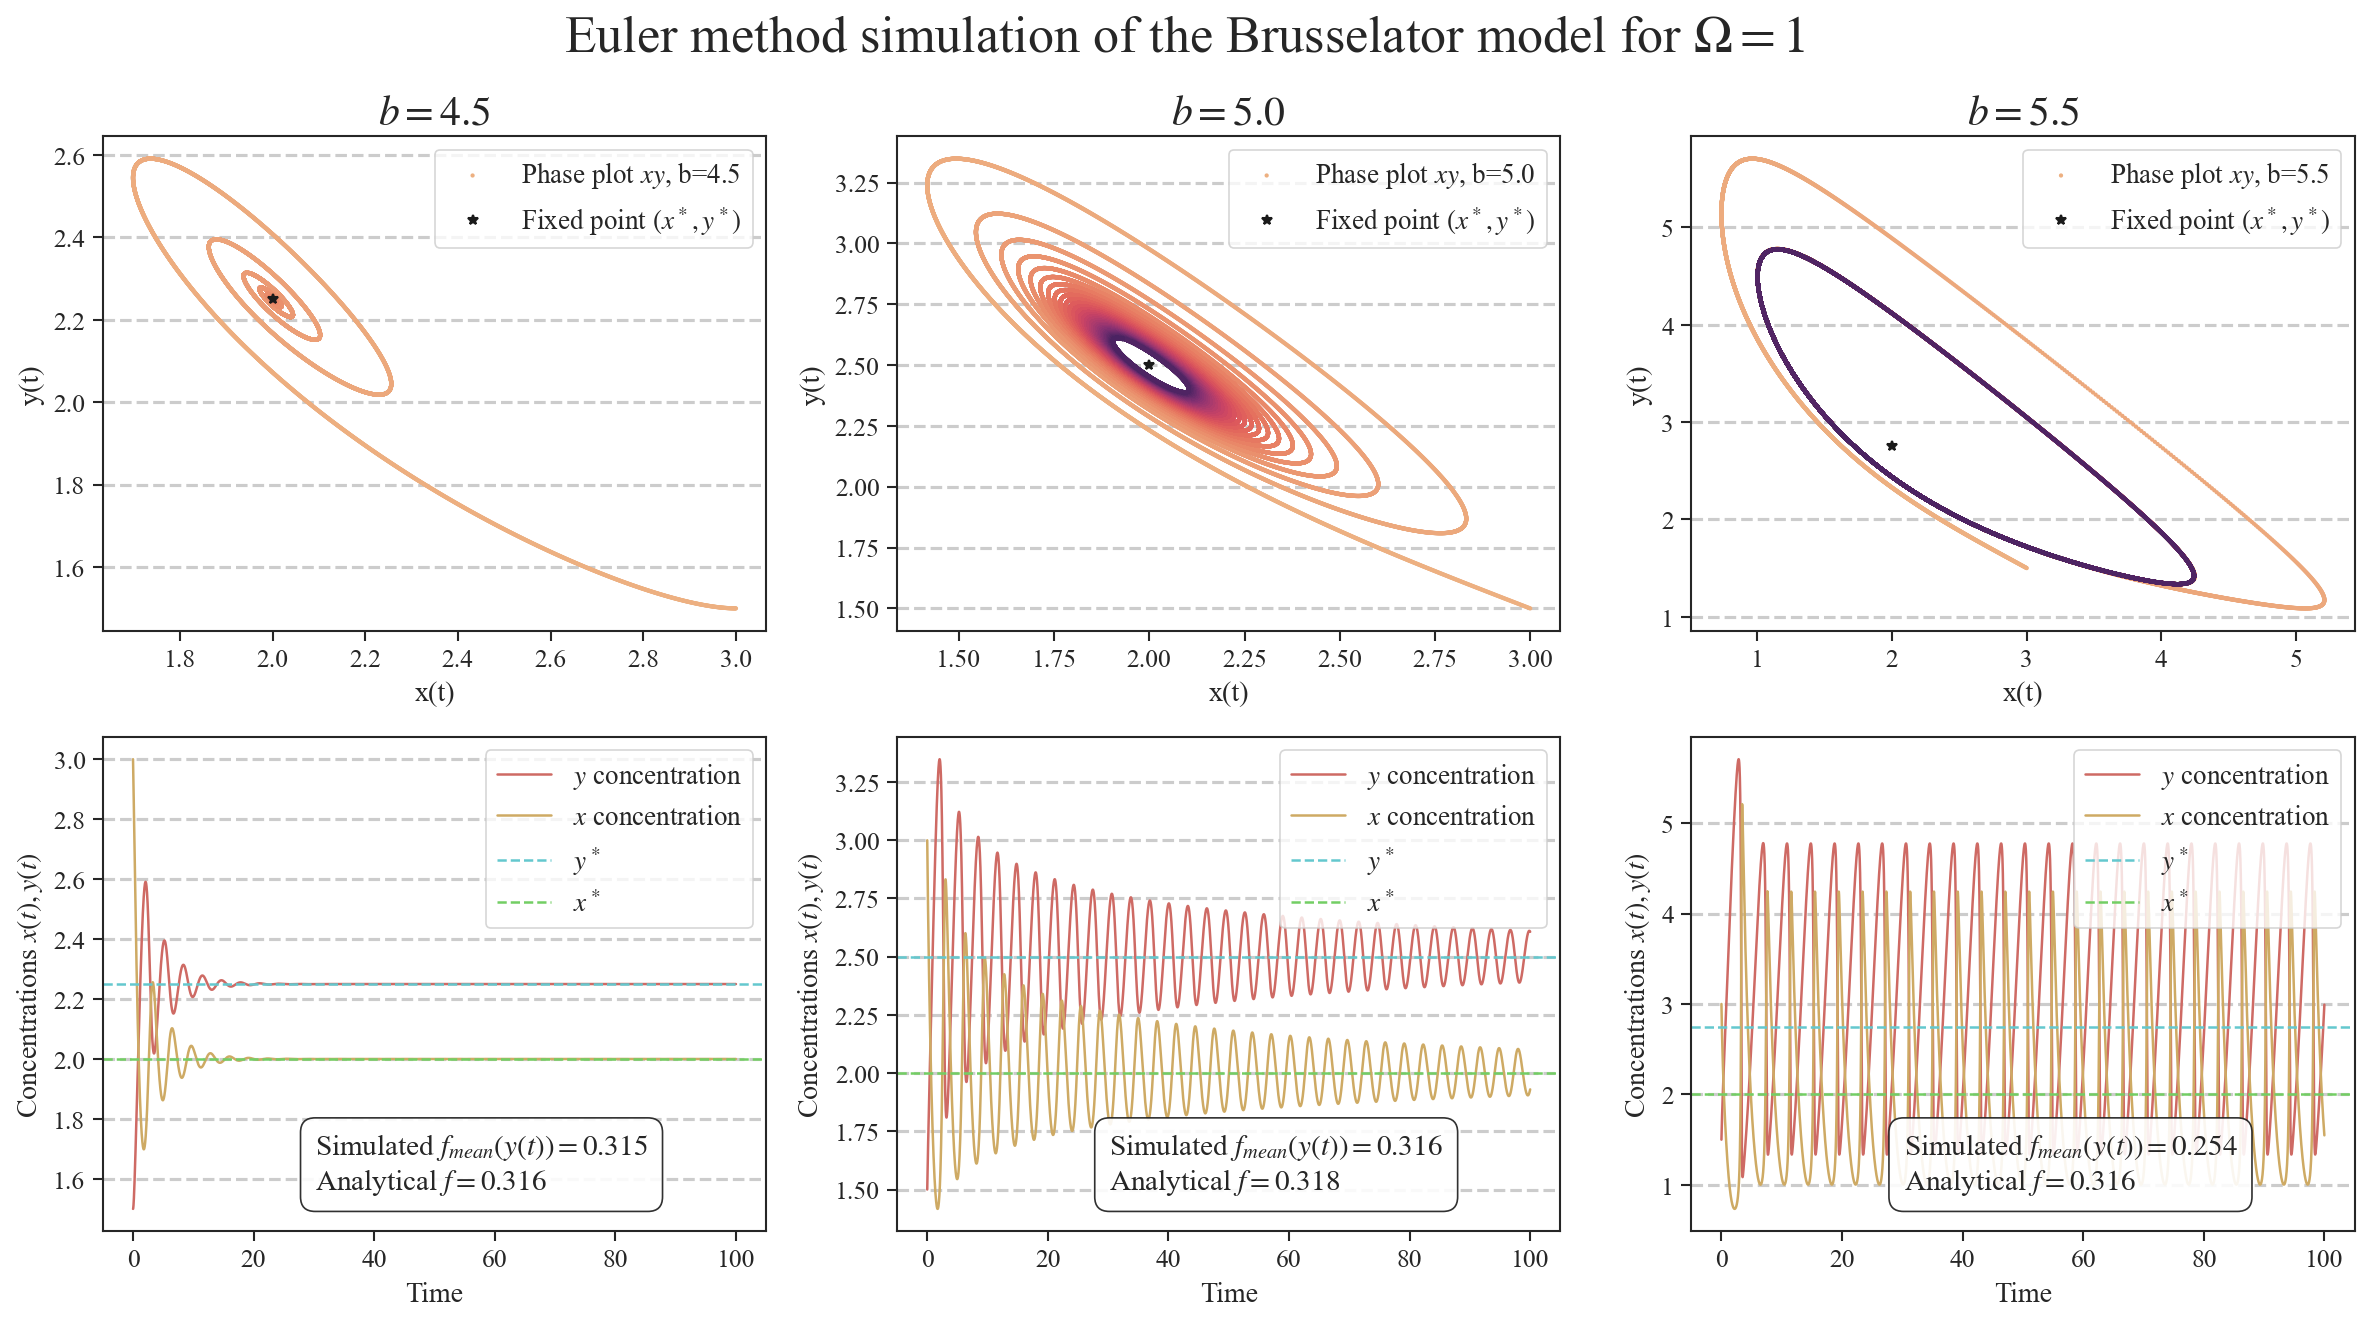

In [98]:

V = 1
var_change = np.array([3, 1.5])
dt_init = 0.001
t_max = 100
a = 2; b=[4.5, 5.,5.5]; c=1; d=1


fig, ax = plt.subplots(2, 3)

for i, j in enumerate(b):
    x_list, y_list, t_list, x_star, y_star, ana_freq, freq_y = euler_sim(var_change, V, dt_init, t_max, np.array([a, j, c, d]))
    
    textstr = '\n'.join((
    r'Simulated $f_{mean}(y(t))=%.3f$' % (freq_y),
    r'Analytical $f=%.3f$' % (ana_freq)))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor='k',  alpha=0.9, pad=0.5)

    ax[0,i].scatter(x_list, y_list, c=t_list, cmap = 'flare', s=1.5, label = r'Phase plot $xy$, b=%.1f' % (j))
    ax[0,i].plot(x_star, y_star, color = 'k', marker='*', ls='', markersize=5, label = r'Fixed point $(x^*, y^*)$')

    ax[0,i].set_xlabel('x(t)')
    ax[0,i].set_ylabel('y(t)')
    ax[0,i].legend(loc='upper right', fontsize=13)
    ax[0,i].set_title(r'$b=%.1f$' % (j), fontsize=20)
    
    ax[1,i].plot(t_list, y_list, label = r'$y$ concentration')
    ax[1,i].plot(t_list, x_list, label = r'$x$ concentration')
    ax[1,i].axhline(y = y_star, color = colors[4], linestyle = '--', label = r'$y^*$')
    ax[1,i].axhline(y = x_star, color = colors[2], linestyle = '--', label = r'$x^*$')
    ax[1,i].text(0.32, 0.2, textstr, transform=ax[1,i].transAxes, fontsize=14,verticalalignment='top', bbox=props)

    ax[1,i].set_xlabel('Time')
    ax[1,i].set_ylabel(r'Concentrations $x(t), y(t)$')
    ax[1,i].legend(loc='upper right', fontsize=13)

fig.suptitle(r'Euler method simulation of the Brusselator model for $\Omega = 1$', fontsize=25)
plt.tight_layout()

plt.savefig('figurer/brusselator_euler.png', dpi=150)

In [99]:
# Malthes opgave

b = np.linspace(5, 8.9, 5000)
a = 2
c = 1
d = 1
V = 1
dt = 0.001
t_max = 100
var_change = np.array([3, 1.5])

ana_freq_list = []
freq_list = []
for i in b:
    x_list, y_list, t_list, x_star, y_star, ana_freq, freq_y = euler_sim(var_change, V, dt, t_max, np.array([a, i, c, d]))
    freq_list.append(freq_y)
    ana_freq_list.append(ana_freq)


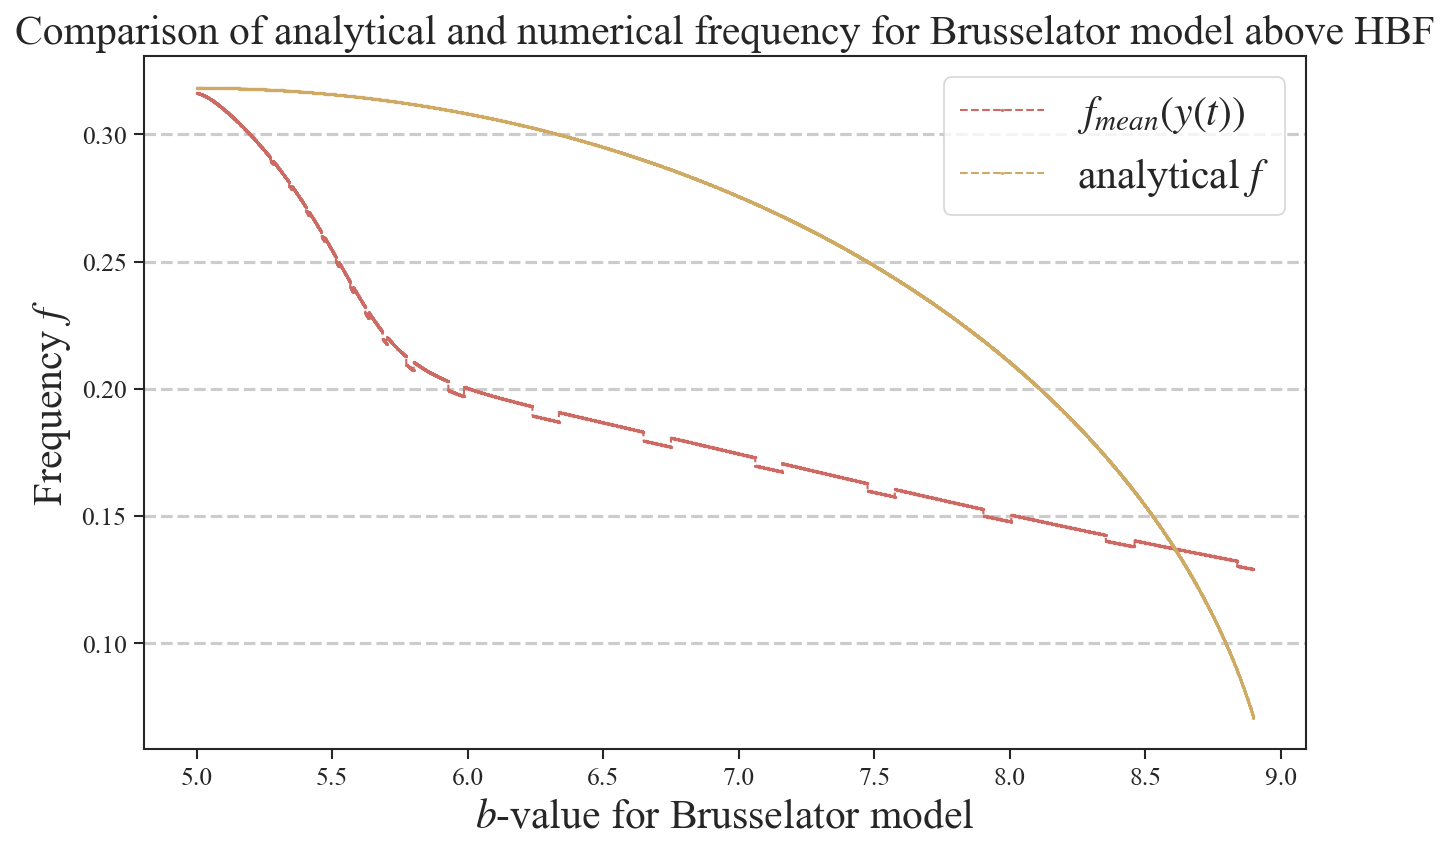

In [100]:
plt.figure(figsize=(10,6))

plt.plot(b, freq_list, label=r'$f_{mean}(y(t))$', marker='.', ls='--', markersize=1, linewidth=1)
plt.plot(b, ana_freq_list, label=r'analytical $f$', marker='.', ls='--', markersize=1, linewidth=1)
plt.xlabel(r'$b$-value for Brusselator model', fontsize=20)
plt.ylabel('Frequency $f$', fontsize=20)
plt.legend(fontsize=20)
plt.title(r'Comparison of analytical and numerical frequency for Brusselator model above HBF', fontsize=20)
plt.savefig('figurer/freq_brusselator.png', dpi=150)

Mean frequency of y(t) from own method is 0.12924767101402412
Mean frequency of y(t) from fft is 0.13


(0.0, 2.0)

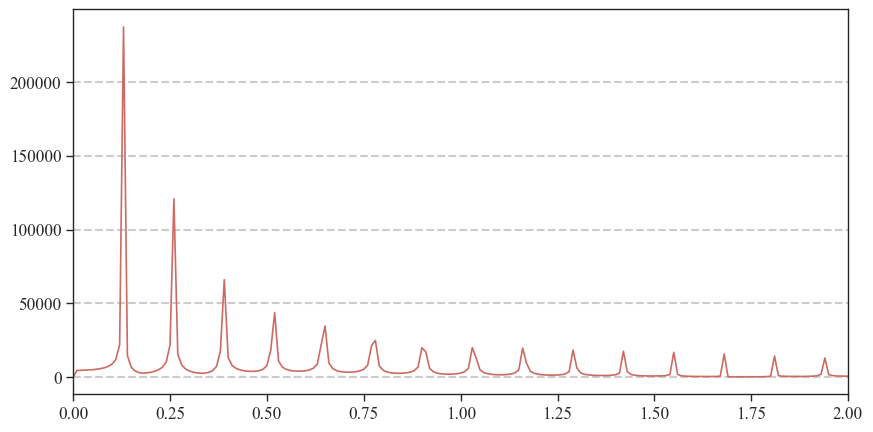

In [101]:
# find the frequency of the peaks with homemade function


# Using fourier transformation np.fft
y_norm = y_list - np.mean(y_list)
fourier_y = np.fft.fft(y_norm)
fourier_y = fourier_y[:len(fourier_y)//2]
freq = np.fft.fftfreq(len(y_list), d=dt_init)
freq = freq[:len(freq)//2]
peak_index = np.argmax(abs(fourier_y))
peak_freq_y = freq[peak_index]



print(f"Mean frequency of y(t) from own method is {freq_y}")
print(f"Mean frequency of y(t) from fft is {peak_freq_y}")

fig, ax = plt.subplots(dpi=100, figsize=(10,5))
ax.plot(freq, abs(fourier_y))
ax.set_xlim(0, 2)

C:\Users\Niels\AppData\Local\Temp\ipykernel_21716\2165600792.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "k." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(x_star, y_star, 'k.', markersize=10, marker='*', label=f'Fixed point for $\Omega = {V}$')


(1.5, 3.0)

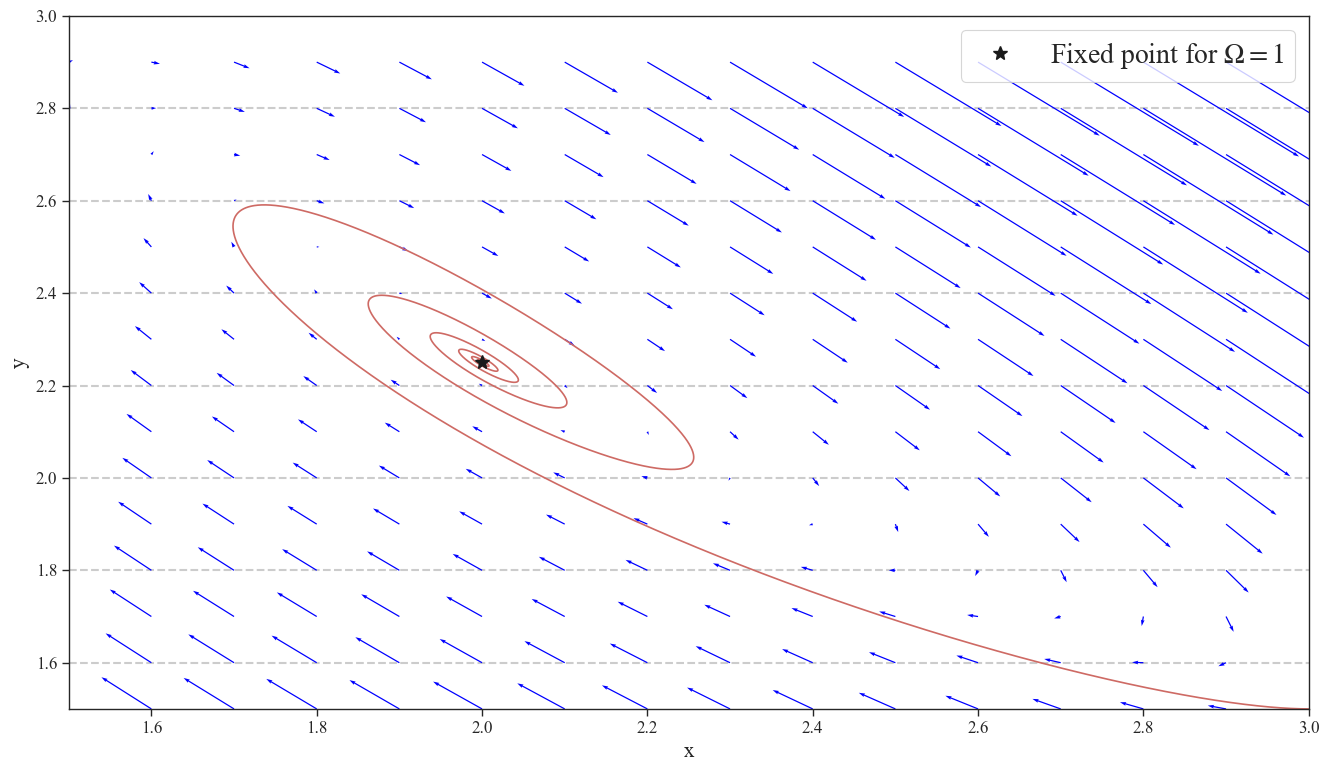

In [102]:
# 2D plot
V = 1
b = 4.5
dt = 0.001
t_max = 100
var_change = np.array([3, 1.5])

params = np.array([a, b, c, d])
x_list, y_list, t_list, x_star, y_star, ana_freq, freq_y = euler_sim(var_change, V, dt_init, t_max, params)

fig = plt.figure(figsize=(16,9), dpi=100)
plt.plot(x_list, y_list)
plt.plot(x_star, y_star, 'k.', markersize=10, marker='*', label=f'Fixed point for $\Omega = {V}$')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)


pair = [1.5, 3]

# Vector field
field_size = np.arange(*pair, 0.1) * V
X, Y = np.meshgrid(field_size, field_size)
U = x_dot_init(X, Y, V, params)
P = y_dot_init(X, Y, V, params)


plt.quiver(X, Y, U, P, angles='xy', width=0.001, color='blue');

plt.xlim(pair)
plt.ylim(pair)


Text(0.5, 1.0, 'Phase portrait for different $\\Omega$')

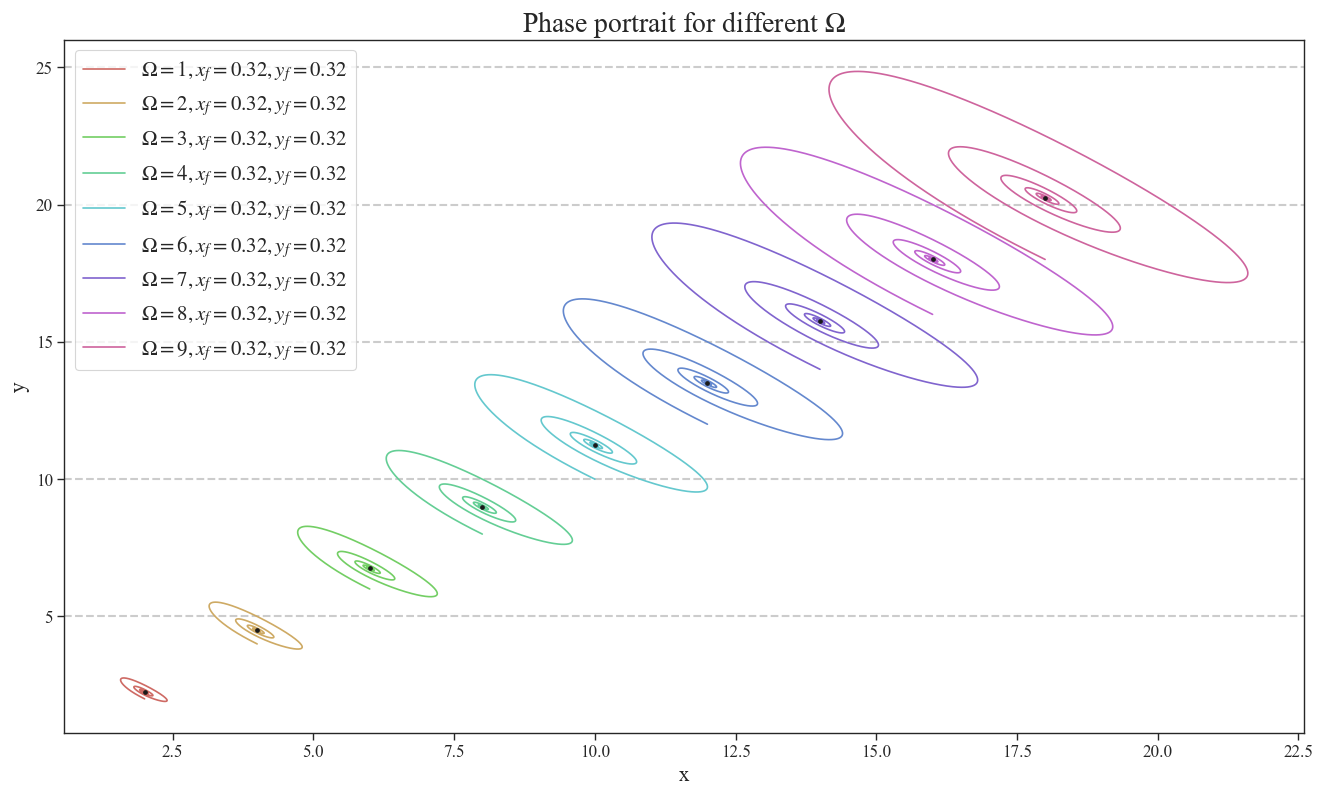

In [103]:
omega = np.arange(1, 10, 1)
var_change = np.array([2, 2])
x_mark_list = []
y_mark_list = []
x_freq_list = []
y_freq_list = []
dt_new = 0.001
t_max_new = 100

plt.figure(figsize=(16,9), dpi=100)
for i in omega:
    x_list_sim, y_list_sim, t_list_sim, x_star, y_star, ana_freq, freq_y = euler_sim(var_change, i, dt_new, t_max_new, params)
    x_mark_list.append(x_mark(i, params))
    y_mark_list.append(y_mark(i, params))
    x_freq = freq_find(x_list_sim, t_list_sim)
    y_freq = freq_find(y_list_sim, t_list_sim)
    
    plt.plot(x_list_sim, y_list_sim, label=rf'$\Omega = {i}, x_f = {x_freq:.2f}, y_f = {y_freq:.2f}$')
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.legend(fontsize=15)

plt.plot(x_mark_list, y_mark_list, 'k.', label='fixed point')
plt.title('Phase portrait for different $\Omega$', fontsize=20)

____

# Adding oscillatory term $ A cos(\omega t)$

In [104]:

@numba.njit
def x_dot(x, y, t, a, b, c, d, V, omega, A):
    dxdt = a*V - (b + d) * x + c/(V**2) * x**2 * y + A * np.cos(omega * t)
    return dxdt

@numba.njit
def y_dot(x, y, V, b, c):
    dydt = b*x - c/(V**2) * x**2 * y
    return dydt

a = 2
b = 4.5
c = 1
d = 1
V = 1

@numba.njit
def euler(var_change, V, omega, A, dt, t_max):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot(x, y, t, a, b, c, d, V, omega, A)
        y += dt * y_dot(x, y, V, b, c)
        t += dt
    return x_list, y_list, t_list

@numba.njit
def amplitude_find(list1, list2, t_list, t_choise = 30):
    t_list = np.array(t_list)
    list1 = np.array(list1)
    list2 = np.array(list2)
    
    mask = np.where(t_list > t_choise)
    list1_mask = list1[mask[0]]
    list2_mask = list2[mask[0]]

    return np.max(list1_mask) - np.min(list1_mask), np.max(list2_mask) - np.min(list2_mask)



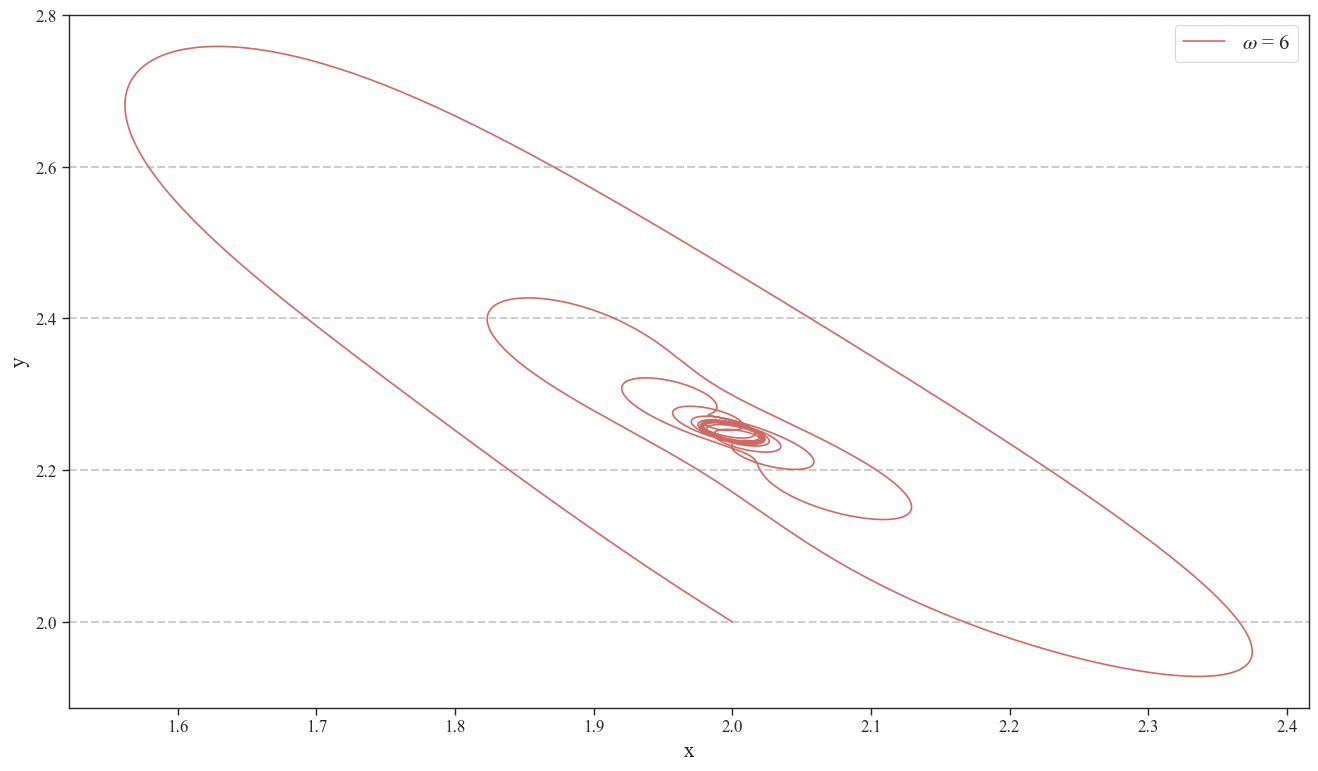

In [105]:
# run euler simulaiton with new x_dot and y_dot functions

omega = np.array([6])
var_change = np.array([2, 2])
A = 0.1
t_max = 100
dt = 0.01

fig, ax = plt.subplots(figsize=(16,9), dpi=100)

for i in omega:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    ax.plot(x_list, y_list, label=f'$\omega$ = {i}')

ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.legend(fontsize=15)




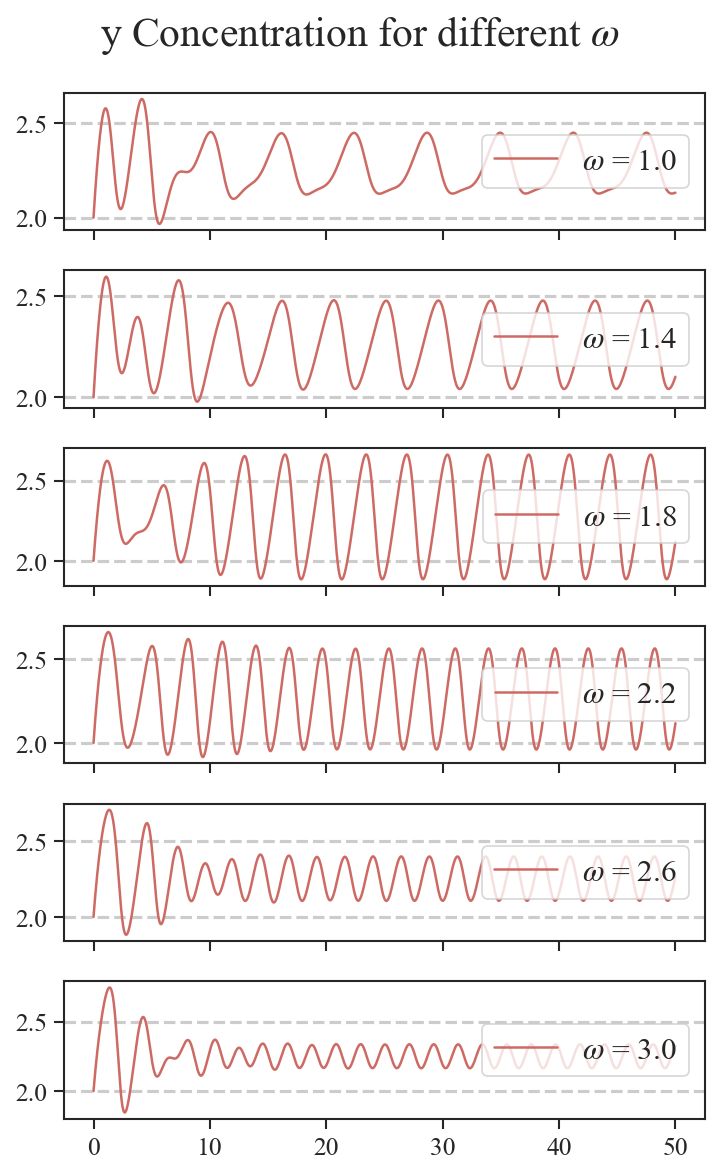

In [106]:
# plot x(t) and y(t) for different omega values

omega = np.linspace(1, 3, 6)
var_change = np.array([2, 2])
A = 0.1
t_max = 50
dt = 0.001

fig_rows = len(omega)
fig, ax = plt.subplots(fig_rows, 1, sharex=True, figsize=(5,8), dpi=150)
ax.flatten()


amp_x = []
amp_y = []

for i, j in enumerate(omega):
    x_list, y_list, t_list = euler(var_change, V, j, A, dt, t_max)
    
    ax[i].plot(t_list, y_list, label=f'$\omega$ = {j}', color = colors[0])
    ax[i].legend(fontsize=15, loc='center right')

fig_ylabel = 'y'
fig_xlabel = 'Time'

fig.suptitle(f'y Concentration for different $\omega$', fontsize=20)
plt.tight_layout()

plt.savefig('figurer/udvalgt_omega.png', dpi=150)


### For a large number of $\omega$ 

In [107]:
omega_list = np.linspace(0.1, 6, 200)    
var_change = np.array([2, 2])
A = 0.1
t_max = 100
dt = 0.01

amp_x = []
amp_y = []

for i in omega_list:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    x_max, y_max = amplitude_find(x_list, y_list, t_list, t_choise=30)
    amp_x.append(x_max)
    amp_y.append(y_max)


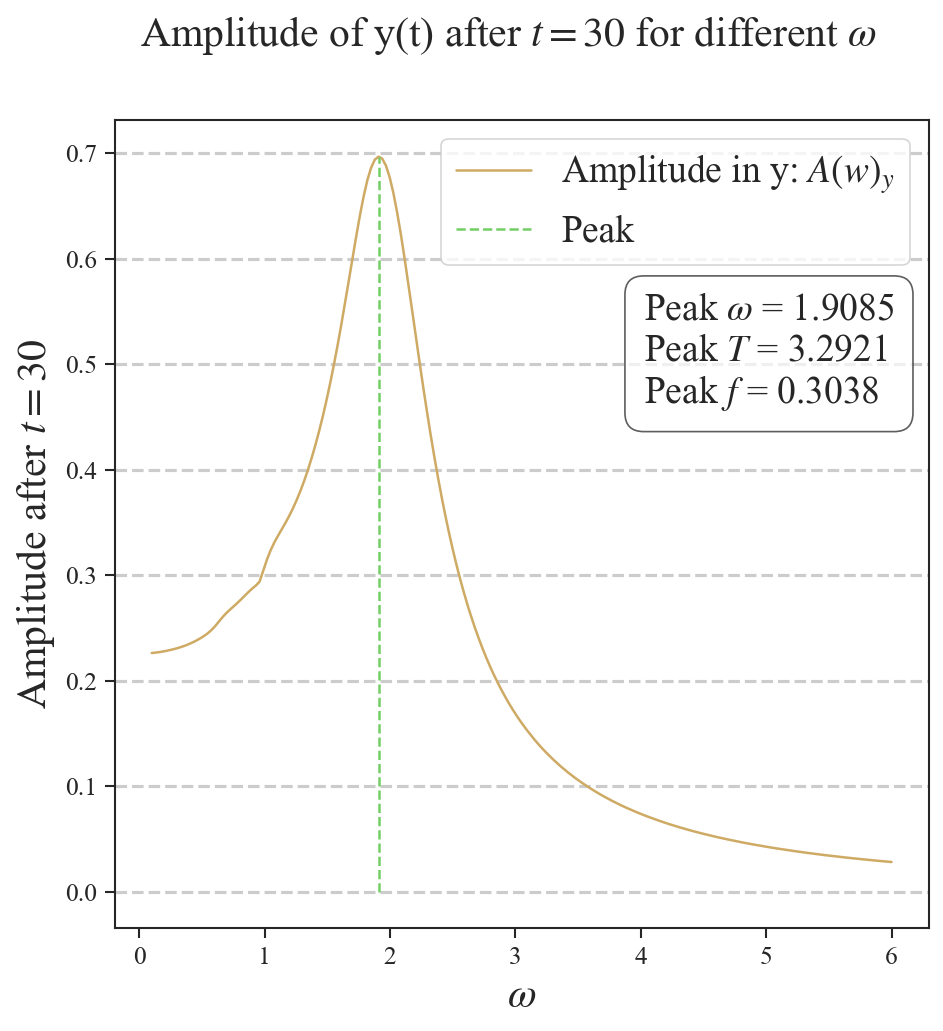

In [108]:
fig, ax = plt.subplots(figsize=(7,7))

# find peak in y
y_peak = np.max(amp_y)
omega_y_peak = omega_list[np.argmax(amp_y)]
f_y_peak = omega_y_peak/(2*np.pi)
T_y = 2*np.pi/omega_y_peak


props = dict(boxstyle='round', facecolor='white', edgecolor='k',  alpha=0.7, pad=0.5)

# Join omega_y_peak and T_y to text
textstr = '\n'.join((
    r'Peak $\omega$ = %.4f' % (omega_y_peak),
    r'Peak $T$ = %.4f' % (T_y),
    r'Peak $f$ = %.4f' % (f_y_peak)))

ax.plot(omega_list, amp_y, label=r'Amplitude in y: $A(w)_y$', color = colors[1])
ax.set_xlabel('$\omega$', fontsize=20)
ax.vlines(omega_y_peak, 0, y_peak, color=colors[2], linestyle='--', label='Peak')
ax.set_ylabel('Amplitude after $t=30$', fontsize=20)
ax.text(0.65, 0.65, textstr, transform=ax.transAxes, fontsize=18, bbox=props);
ax.legend(fontsize=18, loc='upper right')

fig.suptitle('Amplitude of y(t) after $t=30$ for different $\omega$', fontsize=20)

plt.savefig('figurer/changing_omega.png', dpi=150)


____

In [109]:
# ### High pass filter
# 
# # Define the cutoff frequency (in Hz)
# cutoff_frequency = 0.04  # Cutoff frequency for high-pass filter
# sampling_rate = np.mean(dt_list+0.1)
# 
# # Design the filter
# nyquist = 0.5 * sampling_rate  # Nyquist frequency
# normal_cutoff = cutoff_frequency / nyquist  # Normalize the cutoff frequency
# 
# b, a = signal.butter(4, normal_cutoff, btype='high', analog=False)  # 4th order Butterworth filter

